--- 
description: The k-median problem is the problem of clustering data points into k clusters, aiming to minimize the sum of distances...
---

# The K-Median Problem

The k-median problem is the problem of clustering data points into k clusters, aiming to minimize the sum of distances between points belonging to a particular cluster and the data point that is the center of the cluster.
This can be considered a variant of k-means clustering.
For k-means clustering, we determine the mean value of each cluster whereas for k-median we use the median value.
This problem is known as NP-hard.
We describe how to implement the mathematical model of k-median problem with JijModeling and solve it with JijZept.

<!-- k-median問題は、例えばあるデータ点を$k$個のクラスタに分割するとき、そのクラスタに属する点とクラスタ中心となるデータ点との距離の合計を最小にすることを目指す問題のことです。
これはk-meansクラスタリングの派生系とも呼べるものです。k-meansクラスタリングでは、各クラスタの平均値を計算することでクラスタの重心を決定していましたが、k-medianでは中央値を計算します。
この問題はNP困難として知られています。今回はk-median問題の数理モデルをJijModelingで実装し、JijZeptで解いてみましょう。 -->

## Mathematical Model

Let us consider a mathematical model for k-median problem.

<!-- では数理モデルを考えていきましょう。 -->

### Decisioin variables

We denote $x_{i, j}$ to be a binary variable which is 1 if $i$-th data point belongs to the $j$-th median data point and 0 otherwise.
We also use a binary variable $y_j$ which is 1 if $j$-th data point is the median and 0 otherwise.

<!-- $i$番目のデータ点が$j$番目の中央値となるデータ点に属するとき$x_{i, j}=1$、そうでないとき$x_{i, j}=0$となるバイナリ変数を定めます。
また$j$番目のデータ点が中央値となるとき$y_j=1$、そうでないとき$y_j = 0$となるバイナリ変数を用います。数式で表すと -->

$$
x_{i,j} = \begin{cases}
1,~\text{Node $i$ is covered by median $j$}\\
0,~\text{Otherwise}
\end{cases}
$$

$$
y_j = \begin{cases}
1,~\text{Node $j$ is a median.}\\
0,~\text{Otherwise}
\end{cases}
$$

<!-- のようになります。 -->

### Mathematical Model

Our goal is to find a solution that minimizes the sum of the distance between $i$-th data point and $j$-th median point.
We also set three constraints: 
1. A data point must belong to some single median data point, 
2. the number of median points is $k$, 
3. the data points must belong to a median point.

These can be expressed in a mathematical model as follows.

<!-- $i$番目のデータ点と$j$番目の中央値となる点の距離$d_{i, j}$の合計を最小化することを目的関数にします。
また 1. データ点はどこか1つの中央値となるデータ点に属さなければならない、2. 中央値となるデータ点を$k$個決定しなければならない、3. データ点は中央値となる点に属さなければならない という3つの制約を満たす必要があります。
これらを数式で表現すると、以下のようになります。 -->

$$
\begin{aligned}
\min_x &\sum_{i}\sum_j d_{i,j}x_{i,j} \\
\mathrm{s.t.}~&\sum_{j} x_{i,j} = 1,~\forall i\\
&\sum_j y_j = k\\
&x_{i,j} \leq y_j, ~\forall i, j\\
&x_{i,j} \in \{0, 1\} ~\forall i, j\\
&y_j \in \{0, 1\}~\forall j
\end{aligned} \tag{1}
$$

## Modeling by JijModeling

Here, we show an implementation using JijModeling. We first define variables for the mathematical model described above.

<!-- それでは先程の数理モデル実装に必要となる変数を定義しましょう。 -->

In [1]:
import jijmodeling as jm

d = jm.Placeholder("d", ndim=2)
N = d.len_at(0, latex="N")
J = jm.Placeholder("J", ndim=1)
k = jm.Placeholder("k")
i = jm.Element("i", belong_to=(0, N))
j = jm.Element("j", belong_to=J)
x = jm.BinaryVar("x", shape=(N, J.shape[0]))
y = jm.BinaryVar("y", shape=(J.shape[0],))

`d` is a two-dimensional array representing the distance between each data point and the median point.
The number of data points `N` is extracted from the number of elements in `d`.
`J` is a one-dimensional array representing the candidate indices of the median point.
`k` is the number of median points. 
`i` and `j` denote the indices used in the binary variables, respectively.
Finally, we define the binary variables `x` and `y`.

<!-- `d`は各データ点と中央値点との距離を表す2次元配列です。
`d`の要素数からデータ点の数`N`の情報を抽出しています。
`J`は中央値となる点のインデックスの候補を表した1次元配列です。
`k`が最終的に決定される中央値点の数を表します。
`i`, `j`はそれぞれ、バイナリ変数で用いる添字を表します。
最後に、この最適化問題を解くために必要なバイナリ変数`x`, `y`を定義しています。 -->

Then, we implement (1).

<!-- 続いて、式(1)を実装します。 -->

In [2]:
problem = jm.Problem("k-median")
problem += jm.sum([i, j], d[i, j]*x[i, j])
problem += jm.Constraint("onehot", x[i, :].sum() == 1, forall=i)
problem += jm.Constraint("k-median", y[:].sum() == k)
problem += jm.Constraint("cover", x[i, j] <= y[j], forall=[i, j])

With `jm.Constraint("onehot", x[i, :].sum() == 1, forall=i)`, we insert as a constraint that $\sum_j x_{i, j} = 1$ for all $i$.
`jm.Constraint("k-median", y[:].sum() == k)` represents $\sum_j y_j = k$.
`jm.Constraint("cover", x[i, j] <= y[j], forall=[i, j])` requires that $x_{i, j} \leq y_j$ must be for all $i, j$.

<!-- `jm.Constraint("onehot", x[i, :] == 1, forall=i)`で、全ての$i$に対して$\sum_j x_{i, j} = 1$が成り立つことを制約として挿入しています。
`jm.Constraint("k-median", y[:] == k)`は$\sum_j y_j = k$を表します。
`jm.Constraint("cover", x[i, j] <= y[j], forall=[i, j])`は、全ての$i, j$に対して$x_{i, j} \leq y_j$でなければならないことを要請しています。 -->

We can check the implementation of the mathematical model on Jupyter Notebook.

In [3]:
problem

## Prepare instance

We prepare and visualize data points.

<!-- 必要となるデータ点を準備しましょう。 -->

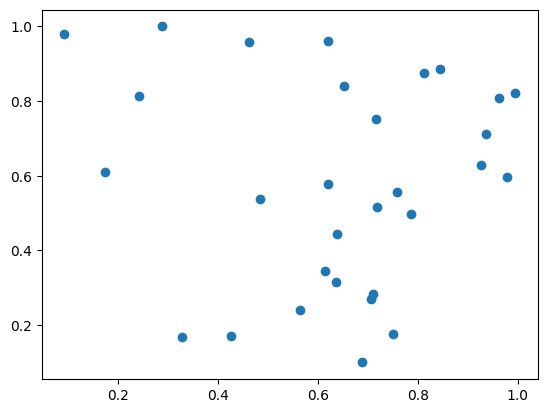

In [4]:
import matplotlib.pyplot as plt
import numpy as np

num_nodes = 30
X, Y = np.random.uniform(0, 1, (2, num_nodes))

plt.plot(X, Y, "o")

We need to calculate the distance between each data point.

<!-- 各データ点どうしの距離を計算しましょう。 -->

In [5]:
XX, XX_T = np.meshgrid(X, X)
YY, YY_T = np.meshgrid(Y, Y)
distance = np.sqrt((XX - XX_T)**2 + (YY - YY_T)**2)

ph_value = {
    "d": distance,
    "J": np.arange(0, num_nodes),
    "k": 4
}

## Solve with JijZept

We solve the problems implemented so far using JijZept `JijSASampler`.
We also use the parameter search function by setting `search=True` here.

<!-- JijZeptの`JijSASampler`を用いて、これまでに実装された問題を解いてみましょう。
またここでは`search=True`とすることで、パラメータサーチ機能を用います。 -->

In [7]:
import jijzept as jz

sampler = jz.JijSASampler(config="config.toml")
response = sampler.sample_model(problem, ph_value, multipliers={"onehot": 1.0, "k-median": 1.0, "cover": 1.0}, search=True)

From the results, we extract the feasible solutions and show the smallest value of the objective function among them.

<!-- 結果から実行可能解を抽出し、その中で目的関数値が最小のものを表示してみましょう。 -->

In [8]:
# get sampleset
sampleset = response.get_sampleset()
# extract feasible solutions
feasible_samples = sampleset.feasibles()
# get the value of feasible objective function
feasible_objectives = [sample.eval.objective for sample in feasible_samples]
# get the lowest value of objective function
lowest_index = np.argmin(feasible_objectives)
# show the result
print(lowest_index, feasible_objectives[lowest_index])

0 6.622000297366702


From the binary variable $y_j$, which data point is used as the median, we get the indices of the data points that are actually used as the median.

<!-- どのデータ点を中央値として用いるかというバイナリ変数$y_i$から、実際に中央値として使われたデータ点のインデックスを抽出してみます。 -->

In [11]:
# check the solution
y_indices = feasible_samples[lowest_index].var_values["y"].values.keys()
median_indices = np.array([index[0] for index in y_indices])
print(median_indices)

[25  1 19 20]


This information allows us to visualize how data points are clustered.

<!-- これらの情報をもとに、実際にデータ点がクラスタリングされた様子を可視化してみましょう。 -->

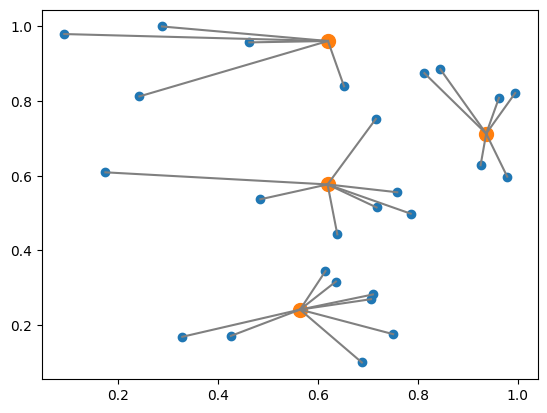

In [12]:
median_X, median_Y = X[median_indices], Y[median_indices]

d_from_m = []
for m in median_indices:
    d_from_m.append(np.sqrt((X - X[m])**2 + (Y - Y[m])**2))

cover_median = median_indices[np.argmin(d_from_m, axis=0)]

plt.plot(X, Y, "o")
plt.plot(X[median_indices], Y[median_indices], "o", markersize=10)
for index in range(len(X)):
    j_value = cover_median[index]
    i_value = index
    plt.plot(X[[i_value, j_value]], Y[[i_value, j_value]], c="gray")

Orange and blue points show the median and other data points respectively. 
The gray line connects the median and the data points belonging to that cluster.
This figure shows how they are into clusters.

<!-- クラスタの中央値となるデータ点を橙色、その他のデータ点を青色で表示しています。また中央値とそのクラスタに属するデータ点を灰色線で結んでいます。
綺麗にクラスタに分類されている様子がわかります。 -->